In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import matplotlib 
from matplotlib import rcParams
import spacy
import seaborn as sns
import statsmodels.api as sm
import ruptures as rpt
import numpy as np
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter

# 1. Descriptive statistics

In [2]:
# Set the font family to Times New Roman
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
matplotlib.rcParams.update({'font.size': 16})

In [3]:
# Import data
data = pd.read_csv('updated_dataset.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12638 entries, 0 to 12637
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   airline                 12638 non-null  object 
 1   ratingValue             12638 non-null  int64  
 2   author                  12638 non-null  object 
 3   country                 12638 non-null  object 
 4   reviewText              12638 non-null  object 
 5   verified                12638 non-null  bool   
 6   type_of_traveller       12636 non-null  object 
 7   cabin_flown             12638 non-null  object 
 8   date_flown              12638 non-null  object 
 9   seat_comfort            11726 non-null  float64
 10  cabin_staff_service     11665 non-null  float64
 11  food_and_beverages      9070 non-null   float64
 12  ground_service          12117 non-null  float64
 13  value_for_money         12636 non-null  float64
 14  inflight_entertainment  6523 non-null 

### Tables

In [5]:
# Filter the data
before_covid = data[(data['year_flown'] >= 2017) & (data['year_flown'] <= 2019)]
during_after_covid = data[(data['year_flown'] >= 2020) & (data['year_flown'] <= 2022)]

# Add a column indicating before or during COVID
before_covid = before_covid.assign(before_during_covid=0)
during_after_covid = during_after_covid.assign(before_during_covid=1)

# Concatenate
data = pd.concat([before_covid, during_after_covid])
data = data.reset_index(drop=True)

data.head(5)

,airline,ratingValue,author,country,reviewText,verified,type_of_traveller,cabin_flown,date_flown,seat_comfort,...,is_english,year_flown,continent,reviewText_char_count,period,processed_review,compound_score,overall_sentiment,sentiment_scores,before_during_covid
0,TAP Portugal,3,9f61d6058d5edd3a0fa2313782b1e1cd41a5f2e1f79d71...,United States,Purchased the tickets December 2019. Airline n...,True,Couple Leisure,Economy Class,August 2019,NaN,...,1,2019,North America,659,0,Purchased the tickets December 2019. Airline n...,-0.8038,Negative,"{'neg': 0.098, 'neu': 0.882, 'pos': 0.021, 'co...",0
1,TAP Portugal,2,4f7a4ff61bf17f3e171b519e935f3085201bb7ea57618f...,United States,"When you fly with TAP, cross your fingers and ...",True,Solo Leisure,Economy Class,October 2019,2.0,...,1,2019,North America,284,0,"When you fly with TAP, cross your fingers and ...",0.2942,Positive,"{'neg': 0.055, 'neu': 0.851, 'pos': 0.094, 'co...",0
2,TAP Portugal,10,b892bffb2c1032d4c5c0b037e65aa5197a62fc8ae31314...,United Kingdom,London Heathrow to Faro via Lisbon. One of my ...,True,Family Leisure,Economy Class,July 2019,5.0,...,1,2019,Europe,520,0,London Heathrow to Faro via Lisbon. One of my ...,0.8896,Positive,"{'neg': 0.067, 'neu': 0.786, 'pos': 0.148, 'co...",0
3,TAP Portugal,1,23304178961e9c4738f20e49226d9a8ce650f0b800dca9...,United Kingdom,Miami to London via Lisbon. Have called and em...,True,Solo Leisure,Economy Class,June 2019,1.0,...,1,2019,Europe,306,0,Miami to London via Lisbon. Have called and em...,-0.6381,Negative,"{'neg': 0.132, 'neu': 0.827, 'pos': 0.04, 'com...",0
4,TAP Portugal,1,8d49e100abe5d4c9c6d2ba9c8727d31d254be39e7096c3...,Sweden,19 Dec 2019 me and my wife had a business clas...,True,Couple Leisure,Business Class,December 2019,2.0,...,1,2019,Europe,1718,0,19 Dec 2019 me and my wife had a business clas...,-0.8843,Negative,"{'neg': 0.061, 'neu': 0.915, 'pos': 0.024, 'co...",0


In [6]:
summary = round(data.describe(),1)
latex_table = summary.to_latex()
print(latex_table)

\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
{} &  ratingValue &  seat\_comfort &  cabin\_staff\_service &  food\_and\_beverages &  ground\_service &  value\_for\_money &  inflight\_entertainment &  wifi\_and\_connectivity &  is\_english &  year\_flown &  reviewText\_char\_count &   period &  compound\_score &  before\_during\_covid \\
\midrule
count &      10794.0 &        9917.0 &               9861.0 &              7570.0 &         10287.0 &          10792.0 &                  5406.0 &                 3019.0 &     10794.0 &     10794.0 &                10794.0 &  10794.0 &         10794.0 &              10794.0 \\
mean  &          3.8 &           2.6 &                  2.9 &                 2.6 &             2.4 &              2.4 &                     2.6 &                    2.1 &         1.0 &      2018.9 &                  829.7 &      0.3 &            -0.0 &                  0.3 \\
std   &          3.3 &           1.4 &                  1.6 &                 1.5 &             1.5 

C:\Users\70608ebe\AppData\Local\Temp\ipykernel_9384\3563767336.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = summary.to_latex()


In [7]:
average_values = round(data.groupby('before_during_covid').mean(),1)
latex_table = average_values.to_latex()
latex_table

C:\Users\70608ebe\AppData\Local\Temp\ipykernel_9384\4073962372.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = average_values.to_latex()


'\\begin{tabular}{lrrrrrrrrrrrrrr}\n\\toprule\n{} &  ratingValue &  verified &  seat\\_comfort &  cabin\\_staff\\_service &  food\\_and\\_beverages &  ground\\_service &  value\\_for\\_money &  inflight\\_entertainment &  wifi\\_and\\_connectivity &  is\\_english &  year\\_flown &  reviewText\\_char\\_count &  period &  compound\\_score \\\\\nbefore\\_during\\_covid &              &           &               &                      &                     &                 &                  &                         &                        &             &             &                        &         &                 \\\\\n\\midrule\n0                   &          4.2 &       1.0 &           2.7 &                  3.0 &                 2.7 &             2.5 &              2.6 &                     2.7 &                    2.1 &         1.0 &      2018.0 &                  827.3 &     0.0 &             0.0 \\\\\n1                   &          3.0 &       1.0 &           2.5 &          

In [8]:
average_values = round(data.groupby('before_during_covid').mean(),1)
average_values

,ratingValue,verified,seat_comfort,cabin_staff_service,food_and_beverages,ground_service,value_for_money,inflight_entertainment,wifi_and_connectivity,is_english,year_flown,reviewText_char_count,period,compound_score
before_during_covid,,,,,,,,,,,,,,
0,4.2,1.0,2.7,3.0,2.7,2.5,2.6,2.7,2.1,1.0,2018.0,827.3,0.0,0.0
1,3.0,1.0,2.5,2.7,2.4,2.1,2.0,2.5,2.0,1.0,2021.2,835.7,1.0,-0.2


In [9]:
std_values = round(data.groupby('before_during_covid').std(),1)
std_values

,ratingValue,verified,seat_comfort,cabin_staff_service,food_and_beverages,ground_service,value_for_money,inflight_entertainment,wifi_and_connectivity,is_english,year_flown,reviewText_char_count,period,compound_score
before_during_covid,,,,,,,,,,,,,,
0,3.4,0.0,1.4,1.6,1.5,1.6,1.6,1.5,1.5,0.0,0.8,579.6,0.0,0.8
1,3.0,0.0,1.4,1.6,1.5,1.5,1.4,1.4,1.4,0.0,0.8,610.4,0.0,0.7


In [10]:
describe = round(data.groupby('before_during_covid')['reviewText_char_count'].describe(),1)
describe

,count,mean,std,min,25%,50%,75%,max
before_during_covid,,,,,,,,
0,7649.0,827.3,579.6,112.0,419.0,664.0,1050.0,4613.0
1,3145.0,835.7,610.4,89.0,403.0,665.0,1063.0,3772.0


In [14]:
average_values = round(data.groupby('cabin_flown').mean(),1)
latex_table = average_values.to_latex()
latex_table

C:\Users\70608ebe\AppData\Local\Temp\ipykernel_9384\1202800624.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = average_values.to_latex()


'\\begin{tabular}{lr}\n\\toprule\n{} &  before\\_during\\_covid \\\\\ncabin\\_flown     &                      \\\\\n\\midrule\nBusiness Class  &                  0.3 \\\\\nEconomy Class   &                  0.3 \\\\\nFirst Class     &                  0.1 \\\\\nPremium Economy &                  0.2 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [19]:
average_values = round(data.groupby(['before_during_covid', 'cabin_flown']).mean(), 1)
latex_table = average_values.to_latex()
average_values

C:\Users\70608ebe\AppData\Local\Temp\ipykernel_9384\2586299956.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = average_values.to_latex()


ratingValue  verified  seat_comfort  \
before_during_covid cabin_flown                                            
0                   Business Class           5.5       1.0           3.1   
                    Economy Class            3.8       1.0           2.6   
                    First Class              6.4       1.0           3.7   
                    Premium Economy          4.8       1.0           3.0   
1                   Business Class           4.3       1.0           2.9   
                    Economy Class            2.7       1.0           2.3   
                    First Class              6.5       1.0           3.6   
                    Premium Economy          4.0       1.0           2.8   

                                     cabin_staff_service  food_and_beverages  \
before_during_covid cabin_flown                                                
0                   Business Class                   3.6                 3.2   
                    Economy Class                    2.9                 2.6   
                    First Class                      4.0                 3.4   
                    Premium Economy                  3.2                 2.8   
1                   Business Class                   3.2                 2.9   
                    Economy Class                    2.5                 2.2   
                    First Class                      4.0                 3.4   
                    Premium Economy                  2.9                 2.7   

                                     ground_service  value_for_money  \
before_during_covid cabin_flown                                        
0                   Business Class              3.1              3.0   
                    Economy Class               2.3              2.5   
                    First Class                 3.6              3.3   
                    Premium Economy             2.9              2.7   
1                   Business Class              2.6              2.5   
                    Economy Class               1.9              1.9   
                    First Class                 3.4              3.0   
                    Premium Economy             2.6              2.5   

                                     inflight_entertainment  \
before_during_covid cabin_flown                               
0                   Business Class                      3.1   
                    Economy Class                       2.5   
                    First Class                         3.2   
                    Premium Economy                     3.0   
1                   Business Class                      3.0   
                    Economy Class                       2.3   
                    First Class                         3.3   
                    Premium Economy                     2.8   

                                     wifi_and_connectivity  is_english  \
before_during_covid cabin_flown                                          
0                   Business Class                     2.7         1.0   
                    Economy Class                      1.9         1.0   
                    First Class                        2.5         1.0   
                    Premium Economy                    2.5         1.0   
1                   Business Class                     2.7         1.0   
                    Economy Class                      1.7         1.0   
                    First Class                        3.7         1.0   
                    Premium Economy                    2.0         1.0   

                                     year_flown  reviewText_char_count  \
before_during_covid cabin_flown                                          
0                   Business Class       2017.9                  919.2   
                    Economy Class        2018.0                  794.7   
                    First Class          2017.8                 1031.9   
            

In [20]:
average_values = round(data.groupby(['before_during_covid', 'type_of_traveller']).mean(), 1)
latex_table = average_values.to_latex()
average_values

C:\Users\70608ebe\AppData\Local\Temp\ipykernel_9384\154306383.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = average_values.to_latex()


ratingValue  verified  seat_comfort  \
before_during_covid type_of_traveller                                        
0                   Business                   4.1       1.0           2.7   
                    Couple Leisure             3.9       1.0           2.5   
                    Family Leisure             3.8       1.0           2.6   
                    Solo Leisure               4.6       1.0           2.8   
1                   Business                   3.1       1.0           2.5   
                    Couple Leisure             3.1       1.0           2.4   
                    Family Leisure             2.5       1.0           2.3   
                    Solo Leisure               3.2       1.0           2.6   

                                       cabin_staff_service  \
before_during_covid type_of_traveller                        
0                   Business                           3.0   
                    Couple Leisure                     2.9   
                    Family Leisure                     2.9   
                    Solo Leisure                       3.1   
1                   Business                           2.7   
                    Couple Leisure                     2.7   
                    Family Leisure                     2.6   
                    Solo Leisure                       2.7   

                                       food_and_beverages  ground_service  \
before_during_covid type_of_traveller                                       
0                   Business                          2.6             2.5   
                    Couple Leisure                    2.6             2.4   
                    Family Leisure                    2.6             2.4   
                    Solo Leisure                      2.9             2.6   
1                   Business                          2.3             2.1   
                    Couple Leisure                    2.4             2.1   
                    Family Leisure                    2.3             1.9   
                    Solo Leisure                      2.5             2.2   

                                       value_for_money  \
before_during_covid type_of_traveller                    
0                   Business                       2.4   
                    Couple Leisure                 2.5   
                    Family Leisure                 2.4   
                    Solo Leisure                   2.8   
1                   Business                       2.0   
                    Couple Leisure                 2.1   
                    Family Leisure                 1.9   
                    Solo Leisure                   2.1   

                                       inflight_entertainment  \
before_during_covid type_of_traveller                           
0                   Business                              2.5   
                    Couple Leisure                        2.7   
                    Family Leisure                        2.8   
                    Solo Leisure                          2.8   
1                   Business                              2.5   
                    Couple Leisure                        2.4   
                    Family Leisure                        2.4   
                    Solo Leisure                          2.5   

                                       wifi_and_connectivity  is_english  \
before_during_covid type_of_traveller                                      
0                   Business                             2.2         1.0   
                    Couple Leisure                       2.0         1.0   
                    Family Leisure                       2.1         1.0   
                    Solo Leisure                         2.1         1.0   
1                   Business                             2.2         1.0   
                    Couple Leisure                       1.9         1.0   
                    Family

### Line plots

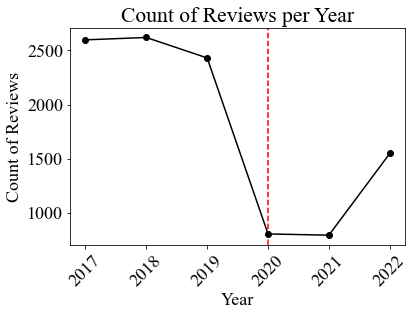

In [81]:
# Group the DataFrame by 'year_flown'
reviews_per_year = data.groupby('year_flown').size()

plt.axvline(x=2020, color='red', linestyle='--')

# Create a line plot
plt.plot(reviews_per_year.index, reviews_per_year.values, marker='o', color = 'black')
plt.xlabel('Year')
plt.ylabel('Count of Reviews')
plt.title('Count of Reviews per Year')
plt.xticks(rotation=45)
plt.show()

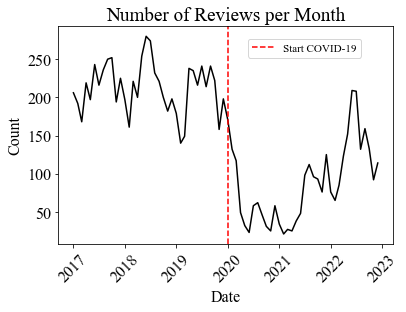

In [204]:
# Convert to datetime format
data['date_flown'] = pd.to_datetime(data['date_flown'])

# Group the data
daily_counts = data.groupby('date_flown').size().reset_index(name='count')

# Create a line plot of the daily counts
plt.plot(daily_counts['date_flown'], daily_counts['count'], color='black')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Number of Reviews per Month')
plt.xticks(rotation=45)
plt.axvline(pd.Timestamp('2020-01-01'), color='red', linestyle='--', label='Start COVID-19')
plt.legend(loc='center left', bbox_to_anchor=(0.55, 0.9), fontsize='x-small')
plt.show()


In [44]:
# Calculate the count
before_covid_counts = before_covid.groupby('date_flown').size().reset_index(name='count').sum()
during_after_covid_counts = during_after_covid.groupby('date_flown').size().reset_index(name='count').sum()

print("Before COVID:")
print(before_covid_counts)
print("\nDuring and After COVID:")
print(during_after_covid_counts)


Before COVID:
count    7649
dtype: int64

During and After COVID:
count    3145
dtype: int64


C:\Users\70608ebe\AppData\Local\Temp\ipykernel_14004\2657362208.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  before_covid_counts = before_covid.groupby('date_flown').size().reset_index(name='count').sum()
C:\Users\70608ebe\AppData\Local\Temp\ipykernel_14004\2657362208.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  during_after_covid_counts = during_after_covid.groupby('date_flown').size().reset_index(name='count').sum()


# 2. Sentiment Analysis

In [7]:
# Filter the data for each period
period1_data = data[data['before_during_covid'] == 0]
period2_data = data[data['before_during_covid'] == 1]

In [8]:
period1_data['year_flown'].unique()
period2_data['year_flown'].unique()

array([2022, 2021, 2020], dtype=int64)

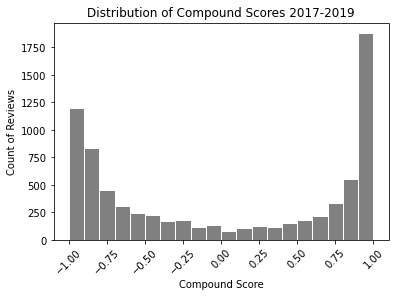

In [9]:
plt.hist(period1_data['compound_score'], bins=20, edgecolor='white', color='grey')

plt.xlabel('Compound Score')
plt.ylabel('Count of Reviews')
plt.title('Distribution of Compound Scores 2017-2019')
plt.xticks(rotation=45)
plt.show()


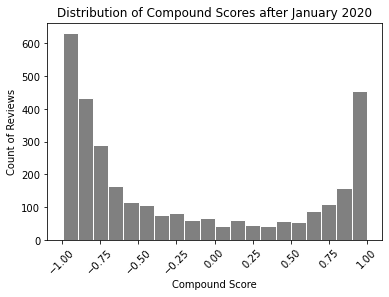

In [10]:
plt.hist(period2_data['compound_score'], bins=20, edgecolor='white', color='grey')

plt.xlabel('Compound Score')
plt.ylabel('Count of Reviews')
plt.title('Distribution of Compound Scores after January 2020')
plt.xticks(rotation=45)
plt.show()


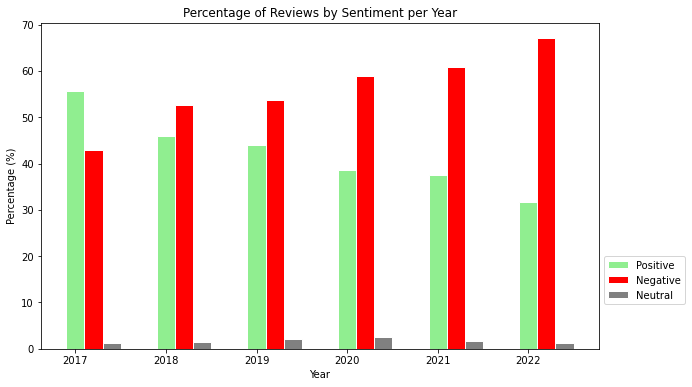

<Figure size 720x576 with 0 Axes>

In [11]:
# Group the data by year and overall sentiment and calculate the count
sentiment_counts = data.groupby(['year_flown', 'overall_sentiment']).size().unstack()

# otalTcount per year
total_counts = sentiment_counts.sum(axis=1)

# Calculate the percentage of each sentiment per year
percentage_positive = (sentiment_counts['Positive'] / total_counts) * 100
percentage_negative = (sentiment_counts['Negative'] / total_counts) * 100
percentage_neutral = (sentiment_counts['Neutral'] / total_counts) * 100


years = sorted(data['year_flown'].unique())


plt.figure(figsize=(10, 6))
bar_width = 0.2
bar_positions = [i for i in range(len(years))]

# Plot the bars for each sentiment
plt.bar(bar_positions, percentage_positive, width=bar_width, label='Positive', color='lightgreen', edgecolor='white')
plt.bar([p + bar_width for p in bar_positions], percentage_negative, width=bar_width, label='Negative', color='red',edgecolor='white')
plt.bar([p + 2 * bar_width for p in bar_positions], percentage_neutral, width=bar_width, label='Neutral', color='gray', edgecolor='white')

# Set the plot title and axes labels
plt.title('Percentage of Reviews by Sentiment per Year')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.xticks(bar_positions, years)
plt.legend(bbox_to_anchor=(1, 0.3), fontsize='medium')
plt.figure(figsize=(10, 8))
plt.show()


In [12]:
# Group the data by year and overall sentiment and calculate the count
sentiment_counts = data.groupby(['year_flown', 'overall_sentiment']).size().unstack()

# Calculate the total count per year
total_counts = sentiment_counts.sum(axis=1)

# Calculate the percentage of each sentiment per year
percentage_positive = (sentiment_counts['Positive'] / total_counts) * 100
percentage_negative = (sentiment_counts['Negative'] / total_counts) * 100
percentage_neutral = (sentiment_counts['Neutral'] / total_counts) * 100

# Create a DataFrame to display the table
table_data = pd.DataFrame({
    'Year': years,
    'Positive (%)': percentage_positive,
    'Negative (%)': percentage_negative,
    'Neutral (%)': percentage_neutral
})

# Display the table
print(table_data)


            Year  Positive (%)  Negative (%)  Neutral (%)
year_flown                                               
2017        2017     55.735181     42.994611     1.270208
2018        2018     45.954198     52.671756     1.374046
2019        2019     44.097079     53.805019     2.097902
2020        2020     38.681592     58.830846     2.487562
2021        2021     37.452711     60.907945     1.639344
2022        2022     31.653747     67.054264     1.291990


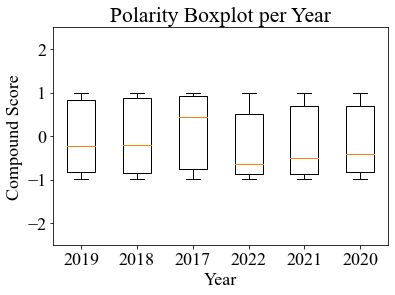

In [92]:
# Group the data by year and extract the compound scores
yearly_scores = [data[data['year_flown'] == year]['compound_score'] for year in data['year_flown'].unique()]

# Set the y-range for the plot
plt.ylim(-2.5, 2.5)

# Create the boxplot
plt.boxplot(yearly_scores, labels=data['year_flown'].unique())

plt.title('Polarity Boxplot per Year')
plt.xlabel('Year')
plt.ylabel('Compound Score')
plt.show()



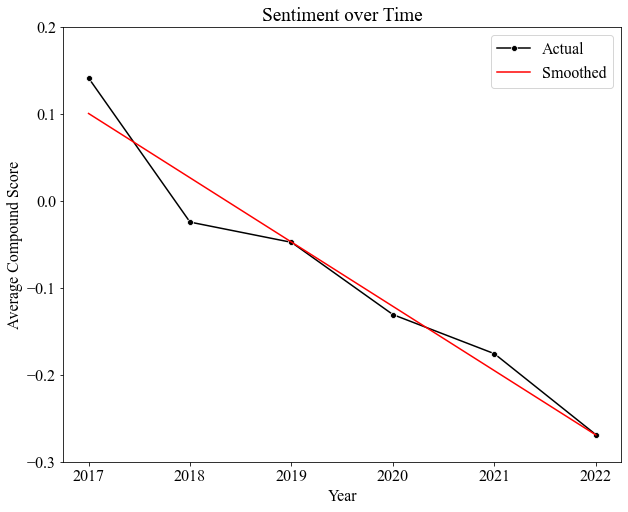

In [203]:
# Group the data by year and calculate the average compound score
average_scores = data.groupby('year_flown')['compound_score'].mean().reset_index()

plt.figure(figsize=(10, 8))

# Fit a GAM smoothing curve
gam_model = sm.GLM(average_scores['compound_score'], sm.add_constant(average_scores['year_flown']), family=sm.families.Gaussian())
gam_result = gam_model.fit()

# Generate predicted values using the GAM model
predictions = gam_result.predict(sm.add_constant(average_scores['year_flown']))

# Plot the actual average compound scores
sns.lineplot(x=average_scores['year_flown'], y=average_scores['compound_score'], marker='o', label='Actual', color = 'black')

# Plot the GAM smoothing curve
sns.lineplot(x=average_scores['year_flown'], y=predictions, label='Smoothed', color = 'red')

plt.ylim(-0.3, 0.2)
plt.title('Sentiment over Time')
plt.xlabel('Year')
plt.ylabel('Average Compound Score')
plt.show()


In [118]:
# Group the data by period and calculate the statistics
statistics = data.groupby('before_during_covid')['compound_score'].describe()

# Extract the desired statistics
mean = statistics['mean']
median = statistics['50%'] 
quartiles = statistics[['25%', '75%']]
std = statistics['std']

# Print the statistics
print("Mean:")
print(mean)
print("\nMedian:")
print(median)
print("\nQuartiles:")
print(quartiles)
print("\nStandard Deviation:")
print(std)

Mean:
before_during_covid
0    0.024491
1   -0.210004
Name: mean, dtype: float64

Median:
before_during_covid
0   -0.0258
1   -0.5574
Name: 50%, dtype: float64

Quartiles:
                        25%     75%
before_during_covid                
0                   -0.8181  0.8958
1                   -0.8720  0.6304

Standard Deviation:
before_during_covid
0    0.789446
1    0.740723
Name: std, dtype: float64


In [25]:
average_values = data.groupby(['before_during_covid', 'type_of_traveller'])['compound_score'].mean()
latex_table = average_values.to_latex()
latex_table


C:\Users\70608ebe\AppData\Local\Temp\ipykernel_9384\1018440252.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = average_values.to_latex()


'\\begin{tabular}{llr}\n\\toprule\n  &              &  compound\\_score \\\\\nbefore\\_during\\_covid & type\\_of\\_traveller &                 \\\\\n\\midrule\n0 & Business &        0.013095 \\\\\n  & Couple Leisure &       -0.032757 \\\\\n  & Family Leisure &       -0.049875 \\\\\n  & Solo Leisure &        0.104268 \\\\\n1 & Business &       -0.204096 \\\\\n  & Couple Leisure &       -0.222966 \\\\\n  & Family Leisure &       -0.298264 \\\\\n  & Solo Leisure &       -0.165540 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Changepoint Analysis

### PELT

IndexError: index 72 is out of bounds for axis 0 with size 72

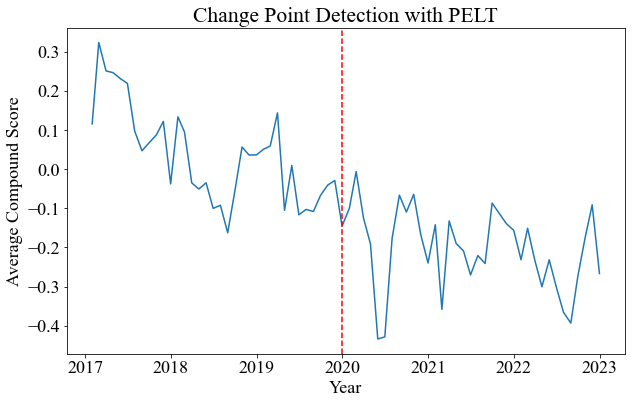

In [208]:
# Extract the sentiment scores and corresponding month values
changepoint_data = data['compound_score'].values
months = pd.to_datetime(data['date_flown'])

# Create a Pandas Series with sentiment scores and month values
series = pd.Series(data=changepoint_data, index=months)

# Resample the series to monthly frequency
series_monthly = series.resample('M').mean()

# PELT
penalty = 5  # Adjust the penalty value
algo_pelt = rpt.Pelt(model="rbf").fit(series_monthly.values[:, np.newaxis])
result_pelt = algo_pelt.predict(pen=penalty)

# Visualize the change points
plt.figure(figsize=(10, 6))
plt.plot(series_monthly.index, series_monthly.values)
plt.title("Change Point Detection with PELT")
plt.xlabel("Year")
plt.ylabel("Average Compound Score")

# Plot vertical lines for the detected change points (PELT)
for cp in result_pelt:
    plt.axvline(x=series_monthly.index[cp], color='red', linestyle='--', label='PELT')

plt.xticks(rotation=90)
plt.legend(['Change Point'])
plt.show()


In [151]:
# Indicate change points
result_pelt

[35, 72]

In [152]:
series_monthly.index[35]

Timestamp('2019-12-31 00:00:00', freq='M')

In [155]:
data['date_flown'] = pd.to_datetime(data['date_flown'], errors='coerce')

# Filter the dataset
start_date = pd.to_datetime('2017-06-01')
end_date = pd.to_datetime('2022-06-30')
filtered_data_v2 = data[(data['date_flown'] >= start_date) & (data['date_flown'] <= end_date)]

IndexError: index 61 is out of bounds for axis 0 with size 61

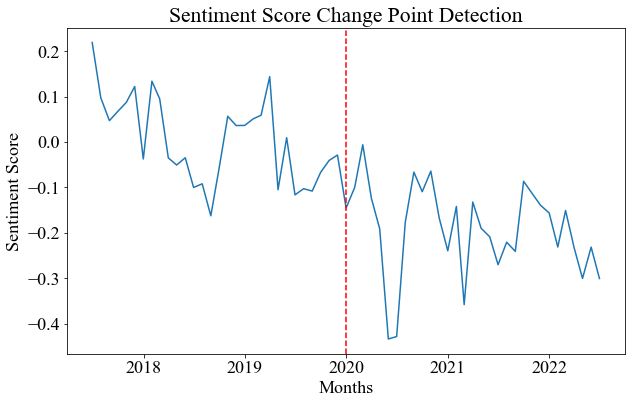

In [158]:
# Extract the sentiment scores and corresponding month values 
changepoint_data = filtered_data_v2['compound_score'].values
months = pd.to_datetime(filtered_data_v2['date_flown'])

series = pd.Series(data=changepoint_data, index=months)

# Resample the series to monthly frequency
series_monthly = series.resample('M').mean()

# PELT
penalty = 5  # Adjust the penalty value
algo_pelt = rpt.Pelt(model="rbf").fit(series_monthly.values[:, np.newaxis])
result_pelt = algo_pelt.predict(pen=penalty)

# Visualize the change points
plt.figure(figsize=(10, 6))
plt.plot(series_monthly.index, series_monthly.values)
plt.title("Sentiment Score Change Point Detection")
plt.xlabel("Months")
plt.ylabel("Sentiment Score")

# Plot vertical lines for the detected change points (PELT)
for cp in result_pelt:
    plt.axvline(x=series_monthly.index[cp], color='red', linestyle='--', label='PELT')

plt.xticks(rotation=90)
plt.legend()
plt.show()

## BinarySeq

IndexError: index 72 is out of bounds for axis 0 with size 72

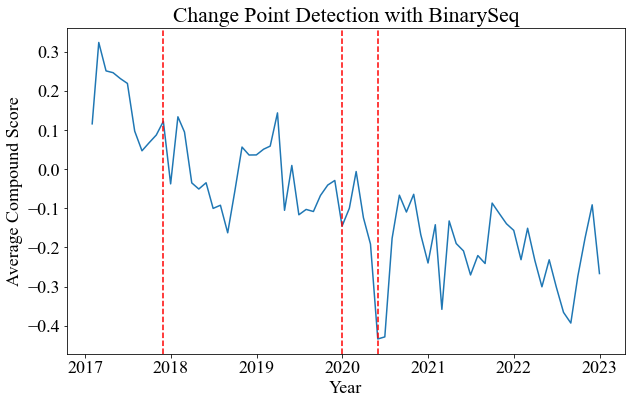

In [207]:
# Extract the sentiment scores and corresponding month values from the DataFrame
changepoint_data = data['compound_score'].values
months = pd.to_datetime(data['date_flown'])

# Create a Pandas Series with sentiment scores and month values
series = pd.Series(data=changepoint_data, index=months)

# Resample the series to monthly frequency
series_monthly = series.resample('M').mean()

# Specify the maximum number of change points
max_size = 3  # Adjust this value based on the expected number of change points

# Binary Segmentation
model = "l2"  # Change this to the desired model
algo_binaryseg = rpt.Binseg(model=model).fit(series_monthly.values[:, np.newaxis])
result_binaryseg = algo_binaryseg.predict(n_bkps=max_size)

# Visualize the change points
plt.figure(figsize=(10, 6))
plt.plot(series_monthly.index, series_monthly.values)
plt.title("Change Point Detection with BinarySeq")
plt.xlabel("Year")
plt.ylabel("Average Compound Score")

# Plot vertical lines for the detected change points (BinarySeg)
for cp in result_binaryseg:
    plt.axvline(x=series_monthly.index[cp], color='red', linestyle='--', label='BinarySeg')

plt.xticks(rotation=90)
plt.legend()
plt.show()


In [167]:
result_binaryseg

[10, 35, 40, 72]

In [170]:
print(series_monthly.index[35])
print(series_monthly.index[40])

2019-12-31 00:00:00
2020-05-31 00:00:00


### Word frequency

In [187]:
positive_reviews = data[data['overall_sentiment'] == 'Positive']
negative_reviews = data[data['overall_sentiment'] == 'Negative']

In [184]:
nlp = spacy.load('en_core_web_sm')

def extract_adj_noun_combinations(review):
    doc = nlp(review)
    adj_noun_combinations = []

    for token in doc:
        if token.pos_ == 'ADJ' and token.head.pos_ == 'NOUN':
            adj_noun_combinations.append(f"{token.text} {token.head.text}")

    return adj_noun_combinations

## POSITIVE REVIEWS

##### ADJ + NOUN

In [189]:
adj_noun_combinations = []

for review in positive_reviews['processed_review']:
    combinations = extract_adj_noun_combinations(review)
    adj_noun_combinations.extend(combinations)

# Count the frequency of adjective + noun combinations
combination_counts = Counter(adj_noun_combinations)

# Get the most common adjective + noun combinations
most_common_combinations = combination_counts.most_common(20)

# Display the most common adjective + noun combinations
for combination, count in most_common_combinations:
    print(f"{combination}: {count}")


other airlines: 284
first time: 206
long haul: 195
short haul: 182
short flight: 165
low cost: 159
next flight: 137
good experience: 119
next day: 114
first flight: 104
good service: 100
middle seat: 98
inflight entertainment: 93
good flight: 89
premium economy: 88
friendly crew: 85
comfortable seats: 76
long flight: 74
other passengers: 72
outbound flight: 70


##### POS ADJ + NOUN

In [191]:
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter

nlp = spacy.load('en_core_web_sm')
analyzer = SentimentIntensityAnalyzer()

positive_adj_noun_combinations = []

for review in positive_reviews['processed_review']:
    doc = nlp(review)
    
    for i, token in enumerate(doc[:-1]):
        if (
            token.pos_ == 'ADJ' and
            analyzer.polarity_scores(token.text)['compound'] > 0 and
            doc[i+1].pos_ == 'NOUN'
        ):
            combination = f"{token.text} {doc[i+1].text}"
            positive_adj_noun_combinations.append(combination)

# Count the frequency of positive adjective + noun combinations
combination_counts = Counter(positive_adj_noun_combinations)

# Get the most common positive adjective + noun combinations
most_common_combinations = combination_counts.most_common(20)

# Display the most common positive adjective + noun combinations
for combination, count in most_common_combinations:
    print(f"{combination}: {count}")


good experience: 102
good flight: 87
good service: 73
nice touch: 61
good selection: 61
good value: 59
pleasant flight: 56
good quality: 54
comfortable seats: 53
pleasant experience: 50
friendly crew: 47
good food: 46
great service: 44
great flight: 43
great experience: 41
good choice: 38
nice flight: 34
comfortable flight: 34
excellent service: 33
friendly staff: 33


##### NOUN + ADJ OR ADJ + NOUN

In [ ]:
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter

nlp = spacy.load('en_core_web_sm')
analyzer = SentimentIntensityAnalyzer()

positive_adj_noun_combinations = []

for review in positive_reviews['processed_review']:
    doc = nlp(review)
    
    for i, token in enumerate(doc[:-1]):
        if (
            (token.pos_ == 'ADJ' and analyzer.polarity_scores(token.text)['compound'] > 0 and doc[i+1].pos_ == 'NOUN') or
            (token.pos_ == 'NOUN' and analyzer.polarity_scores(token.text)['compound'] > 0 and doc[i+1].pos_ == 'ADJ')
        ):
            combination = f"{token.text} {doc[i+1].text}"
            positive_adj_noun_combinations.append(combination)

# Count the frequency of positive adjective + noun and noun + adjective combinations
combination_counts = Counter(positive_adj_noun_combinations)

# Get the most common positive adjective + noun and noun + adjective combinations
most_common_combinations = combination_counts.most_common(20)

# Display the most common positive adjective + noun and noun + adjective combinations
for combination, count in most_common_combinations:
    print(f"{combination}: {count}")


## NEGATIVE REVIEWS

In [192]:
adj_noun_combinations = []

for review in negative_reviews['processed_review']:
    combinations = extract_adj_noun_combinations(review)
    adj_noun_combinations.extend(combinations)

# Count the frequency of adjective + noun combinations
combination_counts = Counter(adj_noun_combinations)

# Get the most common adjective + noun combinations
most_common_combinations = combination_counts.most_common(20)

# Display the most common adjective + noun combinations
for combination, count in most_common_combinations:
    print(f"{combination}: {count}")


next day: 387
next flight: 298
worst experience: 196
other airlines: 188
first time: 177
low cost: 169
worst airline: 146
first flight: 134
new ticket: 129
new flight: 128
poor service: 123
last time: 116
other passengers: 116
online check: 113
last minute: 110
several times: 106
bad experience: 98
worst service: 95
Worst airline: 84
other flights: 83


##### NEG ADJ + NOUN

In [193]:
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter

nlp = spacy.load('en_core_web_sm')
analyzer = SentimentIntensityAnalyzer()

negative_adj_noun_combinations = []

for review in negative_reviews['processed_review']:
    doc = nlp(review)
    
    for i, token in enumerate(doc[:-1]):
        if (
            token.pos_ == 'ADJ' and
            analyzer.polarity_scores(token.text)['compound'] < 0 and
            doc[i+1].pos_ == 'NOUN'
        ):
            combination = f"{token.text} {doc[i+1].text}"
            negative_adj_noun_combinations.append(combination)

# Count the frequency of positive adjective + noun combinations
combination_counts = Counter(negative_adj_noun_combinations)

# Get the most common positive adjective + noun combinations
most_common_combinations = combination_counts.most_common(20)

# Display the most common positive adjective + noun combinations
for combination, count in most_common_combinations:
    print(f"{combination}: {count}")


low cost: 195
worst airline: 162
worst experience: 120
Worst airline: 93
bad experience: 90
worst customer: 81
poor service: 75
terrible experience: 51
worst flight: 49
poor customer: 48
bad weather: 45
rude staff: 41
uncomfortable seats: 40
bad service: 38
poor quality: 37
Worst customer: 36
Terrible experience: 36
bad customer: 34
horrible experience: 32
terrible customer: 30


In [194]:
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter

nlp = spacy.load('en_core_web_sm')
analyzer = SentimentIntensityAnalyzer()

negative_adj_noun_combinations = []

for review in negative_reviews['processed_review']:
    doc = nlp(review)
    
    for i, token in enumerate(doc[:-1]):
        if (
            (token.pos_ == 'ADJ' and analyzer.polarity_scores(token.text)['compound'] < 0 and doc[i+1].pos_ == 'NOUN') or
            (token.pos_ == 'NOUN' and analyzer.polarity_scores(token.text)['compound'] < 0 and doc[i+1].pos_ == 'ADJ')
        ):
            combination = f"{token.text} {doc[i+1].text}"
            negative_adj_noun_combinations.append(combination)

# Count the frequency of positive adjective + noun and noun + adjective combinations
combination_counts = Counter(negative_adj_noun_combinations)

# Get the most common positive adjective + noun and noun + adjective combinations
most_common_combinations = combination_counts.most_common(20)

# Display the most common positive adjective + noun and noun + adjective combinations
for combination, count in most_common_combinations:
    print(f"{combination}: {count}")


low cost: 195
worst airline: 162
worst experience: 120
Worst airline: 93
bad experience: 90
worst customer: 81
poor service: 75
terrible experience: 51
worst flight: 49
poor customer: 48
bad weather: 45
rude staff: 41
uncomfortable seats: 40
bad service: 38
poor quality: 37
Worst customer: 36
Terrible experience: 36
bad customer: 34
horrible experience: 32
terrible customer: 30


## Type of Traveler

In [28]:
# Group the dataset by 'type_of_traveller' column
grouped = data.groupby('type_of_traveller')

# Create an empty DataFrame to store the statistics
stats_df = pd.DataFrame(columns=['Type of Traveller', 'Count', 'Average', 'Standard Deviation', 'Minimum', '25th Percentile', 'Median', '75th Percentile', 'Maximum'])

# Iterate over each group
for group_name, group_df in grouped:
    # Calculate the statistics for the compound score
    count = group_df['compound_score'].count()
    average = group_df['compound_score'].mean()
    std_dev = group_df['compound_score'].std()
    minimum = group_df['compound_score'].min()
    pct25 = np.percentile(group_df['compound_score'], 25)
    median = np.percentile(group_df['compound_score'], 50)
    pct75 = np.percentile(group_df['compound_score'], 75)
    maximum = group_df['compound_score'].max()
    
    # Add the statistics to the DataFrame
    stats_df = stats_df.append({'Type of Traveller': group_name,
                                'Count': count,
                                'Average': average,
                                'Standard Deviation': std_dev,
                                'Minimum': minimum,
                                '25th Percentile': pct25,
                                'Median': median,
                                '75th Percentile': pct75,
                                'Maximum': maximum}, ignore_index=True)

# Print the statistics DataFrame
print(stats_df)


  Type of Traveller Count   Average Standard Deviation Minimum  \
0          Business  1981 -0.040627           0.779065 -0.9928   
1    Couple Leisure  2968 -0.085885           0.774293 -0.9974   
2    Family Leisure  1734 -0.129233           0.778089 -0.9974   
3      Solo Leisure  4109  0.020811           0.787625 -0.9969   

  25th Percentile   Median 75th Percentile Maximum  
0         -0.8337    -0.25          0.8551  0.9987  
1       -0.845725    -0.34        0.817925  0.9982  
2         -0.8689 -0.45665        0.794375   0.999  
3         -0.8109  -0.0375          0.8949  0.9992  


C:\Users\70608ebe\AppData\Local\Temp\ipykernel_9384\465988059.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({'Type of Traveller': group_name,
C:\Users\70608ebe\AppData\Local\Temp\ipykernel_9384\465988059.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({'Type of Traveller': group_name,
C:\Users\70608ebe\AppData\Local\Temp\ipykernel_9384\465988059.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({'Type of Traveller': group_name,
C:\Users\70608ebe\AppData\Local\Temp\ipykernel_9384\465988059.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  s

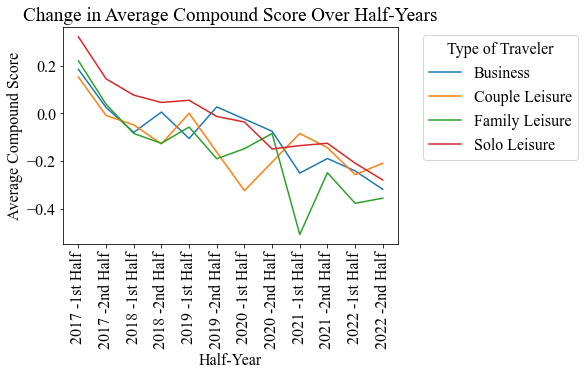

In [36]:
# Extract the month and year from the 'date_flown' column
data['date_flown'] = pd.to_datetime(data['date_flown'])
data['year'] = data['date_flown'].dt.year
data['half_year'] = data['date_flown'].dt.quarter.map({1: '-1st Half', 2: '-1st Half', 3: '-2nd Half', 4: '-2nd Half'})

# Group the dataset by 'type_of_traveller', 'year', and 'half_year' columns
grouped = data.groupby(['type_of_traveller', 'year', 'half_year'])

# Calculate the average compound score for each group
avg_compound_score = grouped['compound_score'].mean()

# Reset the index of the resulting DataFrame
avg_compound_score = avg_compound_score.reset_index()

# Create a line graph with a separate line for each type of traveler
fig, ax = plt.subplots()

for traveler_type, group_df in avg_compound_score.groupby('type_of_traveller'):
    # Combine year and half-year into a single string for x-axis labels
    x_labels = [f"{int(year)} {half_year}" for year, half_year in zip(group_df['year'], group_df['half_year'])]
    ax.plot(x_labels, group_df['compound_score'], label=traveler_type)

# Set the x-axis label
ax.set_xlabel('Time Period')

# Set the y-axis label
ax.set_ylabel('Average Compound Score')

# Set the title
ax.set_title('Change in Average Compound Score Over Half-Years')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add a legend
ax.legend()

# Display the line graph
plt.legend(title='Type of Traveler', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


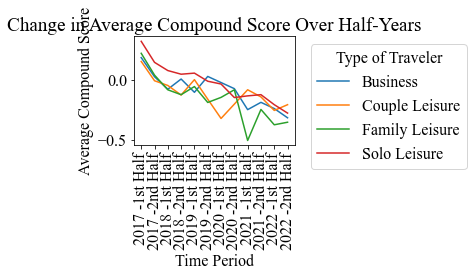

| type_of_traveller   |   year | half_year   |   compound_score |
|:--------------------|-------:|:------------|-----------------:|
| Business            |   2017 | -1st Half   |      0.185101    |
| Business            |   2017 | -2nd Half   |      0.0250805   |
| Business            |   2018 | -1st Half   |     -0.0792952   |
| Business            |   2018 | -2nd Half   |      0.00595726  |
| Business            |   2019 | -1st Half   |     -0.105029    |
| Business            |   2019 | -2nd Half   |      0.0276223   |
| Business            |   2020 | -1st Half   |     -0.0235325   |
| Business            |   2020 | -2nd Half   |     -0.0745667   |
| Business            |   2021 | -1st Half   |     -0.250077    |
| Business            |   2021 | -2nd Half   |     -0.189047    |
| Business            |   2022 | -1st Half   |     -0.240888    |
| Business            |   2022 | -2nd Half   |     -0.318304    |
| Couple Leisure      |   2017 | -1st Half   |      0.153046    |
| Couple L

In [37]:
from tabulate import tabulate

# Extract the month and year from the 'date_flown' column
data['date_flown'] = pd.to_datetime(data['date_flown'])
data['year'] = data['date_flown'].dt.year
data['half_year'] = data['date_flown'].dt.quarter.map({1: '-1st Half', 2: '-1st Half', 3: '-2nd Half', 4: '-2nd Half'})

# Group the dataset by 'type_of_traveller', 'year', and 'half_year' columns
grouped = data.groupby(['type_of_traveller', 'year', 'half_year'])

# Calculate the average compound score for each group
avg_compound_score = grouped['compound_score'].mean()

# Reset the index of the resulting DataFrame
avg_compound_score = avg_compound_score.reset_index()

# Create a line graph with a separate line for each type of traveler
fig, ax = plt.subplots()

for traveler_type, group_df in avg_compound_score.groupby('type_of_traveller'):
    # Combine year and half-year into a single string for x-axis labels
    x_labels = [f"{int(year)} {half_year}" for year, half_year in zip(group_df['year'], group_df['half_year'])]
    ax.plot(x_labels, group_df['compound_score'], label=traveler_type)

# Set the x-axis label
ax.set_xlabel('Time Period')

# Set the y-axis label
ax.set_ylabel('Average Compound Score')

# Set the title
ax.set_title('Change in Average Compound Score Over Half-Years')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add a legend
ax.legend(title='Type of Traveler', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the line graph
plt.tight_layout()
plt.show()

# Convert the data into a table
table = tabulate(avg_compound_score, headers='keys', tablefmt='pipe', showindex=False)

# Print the table
print(table)
